In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/data-2.csv
/kaggle/input/precog-assignment/state_time.png
/kaggle/input/precog-assignment/state_cases.png
/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-assignment/keys/cases_district_key.csv
/kaggle/input/precog-assignment/keys/act_key.csv
/kaggle/input/precog-assignment/keys/disp_n

In [2]:
import dask.dataframe as dd
import gc
from datetime import date
from IPython.display import Image

In [3]:
ja_merge_df = dd.read_csv("../input/precog-assignment/Judge_Act_merge.csv")
ja_merge_df.head()

,ddl_case_id,ddl_judge_id,act,section,criminal,female_judge
0,01-01-01-201900000022018,5.0,4759.0,1123673.0,1.0,0 nonfemale
1,01-01-01-201900000032017,5.0,4759.0,1123673.0,1.0,0 nonfemale
2,01-01-01-201900000042016,5.0,17353.0,865403.0,1.0,0 nonfemale
3,01-01-01-201900000052018,5.0,4759.0,1123673.0,1.0,0 nonfemale
4,01-01-01-201900000072016,5.0,4759.0,132871.0,1.0,0 nonfemale


In [4]:
case_2018 = dd.read_csv("../input/precog-assignment/cases/cases_2018.csv",usecols=["ddl_case_id","date_of_filing","date_of_decision","state_code"])
case_2018.head()

,ddl_case_id,state_code,date_of_filing,date_of_decision
0,01-01-01-201900000012018,1,2018-01-01,2018-02-07
1,01-01-01-201900000022018,1,2018-01-01,2018-02-01
2,01-01-01-201900000032018,1,2018-01-01,2018-02-01
3,01-01-01-201900000042018,1,2018-01-01,2018-02-01
4,01-01-01-201900000052018,1,2018-01-01,2018-01-09


In [5]:
merged_dfd = ja_merge_df.merge(case_2018,on=["ddl_case_id"],how="inner")
merged_dfd.head()

,ddl_case_id,ddl_judge_id,act,section,criminal,female_judge,state_code,date_of_filing,date_of_decision
0,02-17-04-202106002342018,24924.0,17353.0,1182576.0,1.0,1 female,2,2018-09-07,2018-09-08
1,02-17-24-202100000582018,24787.0,17353.0,841964.0,1.0,0 nonfemale,2,2018-02-10,2018-02-10
2,02-17-24-202100001272018,24787.0,17353.0,841964.0,1.0,0 nonfemale,2,2018-04-22,2018-04-22
3,02-17-24-202100002872018,24787.0,17353.0,1140567.0,1.0,0 nonfemale,2,2018-06-22,2018-07-14
4,02-17-24-202100001622018,24789.0,17353.0,768685.0,1.0,0 nonfemale,2,2018-03-23,NaN


In [6]:
merged_df = merged_dfd.dropna(subset=["date_of_decision"]).compute()
merged_dfd = merged_dfd.compute()

In [7]:
from datetime import date
def days_elapsed(date1,date2):
    d1s = date1.split("-")
    d2s = date2.split("-")
    d1s = [int(i) for i in d1s]
    d2s = [int(i) for i in d2s]
    d1 = date(d1s[0],d1s[1],d1s[2])
    d2 = date(d2s[0],d2s[1],d2s[2])
    return (d2 - d1).days

In [8]:
merged_df.drop(["ddl_case_id","ddl_judge_id"],axis=1,inplace=True)
merged_df["time_taken"] = merged_df.apply(lambda x: days_elapsed(x["date_of_filing"],x["date_of_decision"]),axis=1)
merged_df.drop(["date_of_filing","date_of_decision"],axis=1,inplace=True)

In [9]:
state_grouped = (merged_df.groupby(["state_code"])["time_taken"].mean().reset_index(drop=False))
state_grouped.head()

,state_code,time_taken
0,1,40.480583
1,2,75.588833
2,3,58.867096
3,4,137.024578
4,5,26.375783


In [10]:
state_grouped = state_grouped.sort_values(by=["time_taken"],ascending=False)


In [11]:
state_key = pd.read_csv("../input/precog-assignment/keys/cases_state_key.csv",usecols=["year","state_code","state_name"])
state_2018 = state_key[state_key["year"]==2018].drop(["year"],axis=1)

# Average time taken per case by state

The below data visulaization shows the Average time taken per case split up by state. The 10 worst states in this category,i.e the sates which take the most time on case per average, are shown by the next cell. 

The next cell shows a heatmap of India, giving a different visualization medium for the same information, with the darker shades representing the average time_taken being large.

In [12]:
state_grouped = state_grouped.merge(state_2018,on=["state_code"],how="inner")
state_grouped.head(10)

,state_code,time_taken,state_name
0,4,137.024578,Kerala
1,20,107.485759,Tripura
2,19,104.761905,Mizoram
3,29,95.777044,Telangana
4,6,88.217422,Assam
5,17,84.794141,Gujarat
6,11,77.597124,Orissa
7,2,75.588833,Andhra Pradesh
8,15,70.308956,Uttarakhand
9,16,60.316588,West Bengal


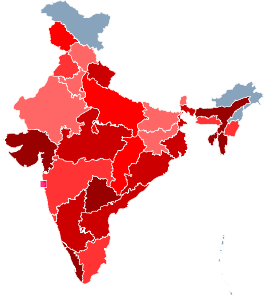

In [13]:
Image(filename='../input/precog-assignment/state_time.png') 

# No of cases by state

The below data visulaization shows the No of cases split up by state. The 10 worst states in this category,i.e the states which have the most cases, are shown by the next cell.

The next cell shows a heatmap of India, giving a different visualization medium for the same information, with the darker shades representing the no of cases being large.


In [14]:
state_count = (merged_dfd.groupby(["state_code"]).size().reset_index(drop=False,name="no_of_cases"))
state_count = state_count.merge(state_2018,how="inner",on=['state_code'])
state_count = state_count.sort_values(by=["no_of_cases"],ascending=False)
state_count.head(10)

,state_code,no_of_cases,state_name
12,13,762972,Uttar Pradesh
22,23,191700,Madhya Pradesh
8,9,170922,Rajasthan
6,7,164712,Jharkhand
0,1,148094,Maharashtra
15,16,137303,West Bengal
2,3,114525,Karnataka
25,26,109116,Delhi
9,10,84343,Tamil Nadu
16,17,82557,Gujarat


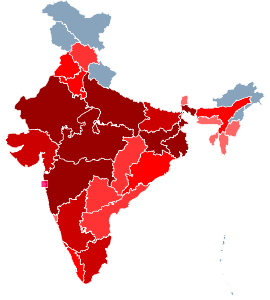

In [15]:
Image(filename='../input/precog-assignment/state_cases.png') 

In [16]:
double_df = state_count.merge(state_grouped,on=["state_code","state_name"],how="inner")
double_df.head()

,state_code,no_of_cases,state_name,time_taken
0,13,762972,Uttar Pradesh,55.470929
1,23,191700,Madhya Pradesh,56.698467
2,9,170922,Rajasthan,35.320628
3,7,164712,Jharkhand,24.293944
4,1,148094,Maharashtra,40.480583


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

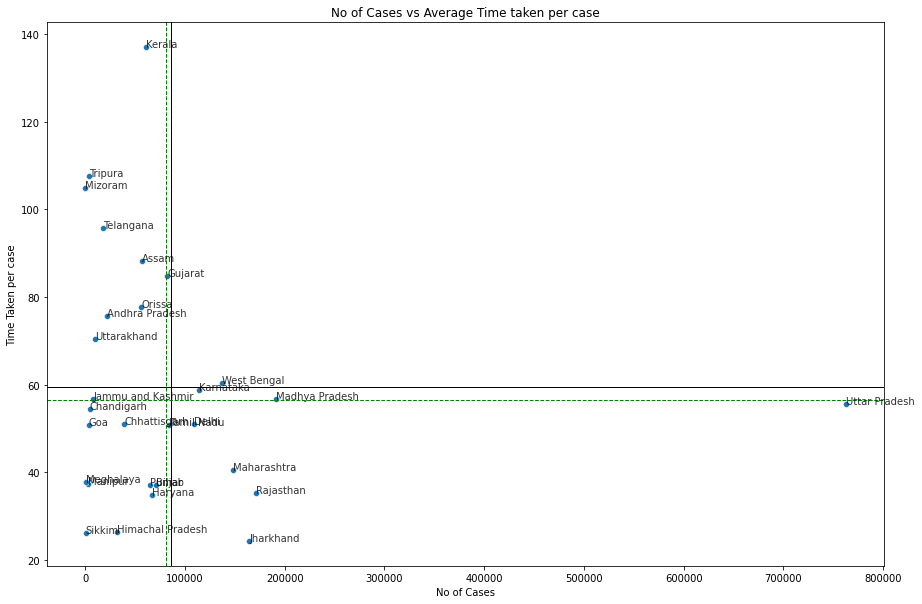

In [18]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=double_df, x='no_of_cases', y='time_taken')
plt.title(f"No of Cases vs Average Time taken per case")
plt.xlabel("No of Cases")
plt.ylabel("Time Taken per case")
          
for i in range(double_df.shape[0]):
          plt.text(double_df.no_of_cases[i], y=double_df.time_taken[i], s=double_df.state_name[i], alpha=0.8)
        
plt.axhline(y=double_df.time_taken.mean(), color='k', linestyle='-', linewidth=1)           
plt.axvline(x=double_df.no_of_cases.mean(), color='k',linestyle='-', linewidth=1) 
plt.axhline(y=0.95*double_df.time_taken.mean(), color='g', linestyle='--', linewidth=1)  
plt.axvline(x=0.95*double_df.no_of_cases.mean(), color='g',linestyle='--', linewidth=1) 

plt.show()

# Data Analysis 1

The above date is 4 quadrant scatterplot with x-axis representing "No of cases" and the y-axis representing the "Average time taken per case". On the graph is 2 pairs of horizontal and vertical lines. The black solid lines indicate the average values, and the green dotted lines indicate 95 % of the average value. 

The graph shows that only West Bengal is above the national average in both no_of_cases and time taken per case in the year 2018. If we expand teh region to include the states that are atleast 95% of the average in both categories, we get Gujarat, Jammu and Kashmir, Karnataka and Madhya Pradesh. 

In [19]:
jf = pd.read_csv("../input/precog-assignment/judges_clean/judges_clean.csv",usecols=["female_judge","state_code"])
jf.head()

,state_code,female_judge
0,1,0 nonfemale
1,1,0 nonfemale
2,1,0 nonfemale
3,1,0 nonfemale
4,1,0 nonfemale


In [20]:
jf_count = jf.groupby(["state_code"]).size().reset_index(drop=False,name="total")
jf_count.head()

,state_code,total
0,1,22440
1,2,3508
2,3,6815
3,4,3107
4,5,915


In [21]:
jf_fem = jf[jf["female_judge"] == "1 female"]
jf_fem = jf_fem.groupby(["state_code"]).size().reset_index(drop=False,name="female")
jf_fem.head()

,state_code,female
0,1,6231
1,2,1226
2,3,2064
3,4,864
4,5,252


In [22]:
jf_comb = jf_fem.merge(jf_count,on=["state_code"],how="inner")
jf_comb["fem_percentage"] = jf_comb.apply(lambda x: 100* (x["female"]/x["total"]),axis=1)
jf_comb = jf_comb.merge(state_2018,on=["state_code"],how="inner")
jf_comb = jf_comb.sort_values(by=["fem_percentage"],ascending=False)

In [23]:
fem_comb = jf_comb.merge(state_grouped,on=["state_name","state_code"],how="inner")
fem_comb.head()

,state_code,female,total,fem_percentage,state_name,time_taken
0,21,92,148,62.162162,Meghalaya,37.688442
1,24,97,167,58.083832,Sikkim,26.203526
2,19,24,44,54.545455,Mizoram,104.761905
3,30,164,337,48.664688,Goa,50.666957
4,25,49,113,43.362832,Manipur,37.273604


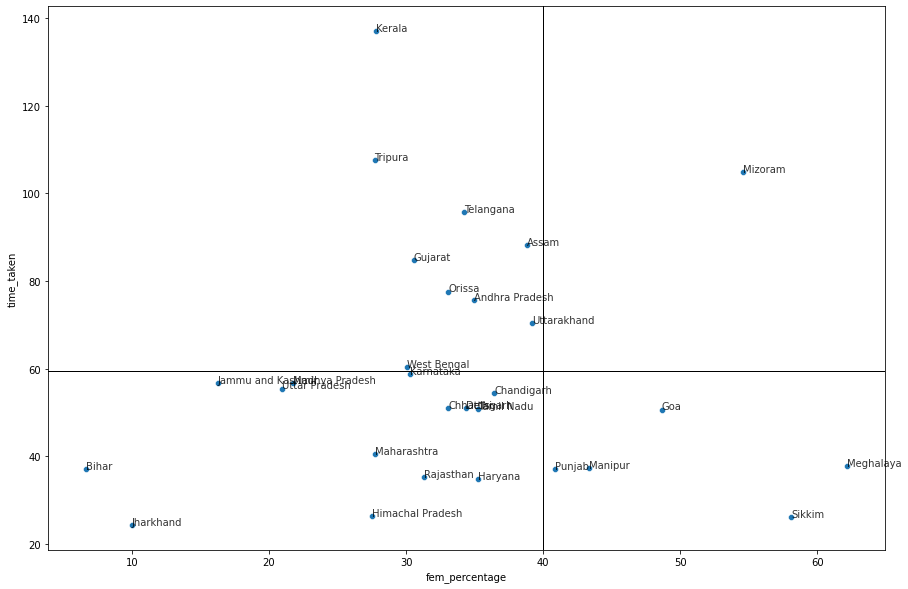

In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=fem_comb, x='fem_percentage', y='time_taken')
# plt.title(f"No of Cases vs Average Time taken per case")
# plt.xlabel("No of Cases")
# plt.ylabel("Time Taken per case")
          
for i in range(fem_comb.shape[0]):
          plt.text(fem_comb.fem_percentage[i], y=fem_comb.time_taken[i], s=fem_comb.state_name[i], alpha=0.8)
        
plt.axhline(y=fem_comb.time_taken.mean(), color='k', linestyle='-', linewidth=1)           
plt.axvline(x=40, color='k',linestyle='-', linewidth=1) 
# plt.axhline(y=0.95*double_df.time_taken.mean(), color='g', linestyle='--', linewidth=1)  
# plt.axvline(x=0.95*double_df.no_of_cases.mean(), color='g',linestyle='--', linewidth=1) 

plt.show()

# Data Analysis 2

The graph above allows us to see the correlation between the percentage of female judges in a state and the average time taken to decide a case.

The graph shows us that among the 6 states whose perecntage of female judges is higher than the provided 40 percent threshold, 5 of them have their average time-taken well below the national average, with Mizoram the lone outlier.

# Insight

From the above data analysis, we can gleam the following insights:

**1.West Bengal, Gujarat and the other states that were seen to be above or close to the national average in both No of cases and average time taken to handle cases are the places where resources are needed to help with the judicial system. These states also might be a startng to point to begin the implementation of a legal AI system to help augment the judicial process**

**2.The infusion of female judges into the judciary seems to have a positive effect on the time taken to decide a case. While it is clearly not the only factor at play, understanding this correlation may help in improving the judicial syatem in India.**